## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#For the creation of the Model
import torch
import torch.nn.functional as F
import torch.optim as optim

## Rewards and States

In [2]:
states = {          #Creates the basic states within the gridworld.
    'start': (0,4), #The starting location of the agent
    'goal':(4, 0),  #The goal that the agent is moving towards.
    'obstacles':[(1, 1), (1, 2), (1, 3), (3, 3), (3, 4)]      #Obstacles that the agent has to learn to go around.
}

rewards = {     #Dictionary of rewards within the gridworld.
    'step': -1,          #The reward given from each step in the gridworld.
    'obstacle': -10,     #The reward given to the agent for trying to run into a wall block.
    'goal': 10                #The reward given by reaching the goal.
}

## Creating the Gridworld

### Gridworld functions

In [3]:
def create_gridworld(rows, columns):
    '''
    Gridworld framework function to be configured by rows, columns, obstacles,
    rewards, terminal state, and returns the gridworld states.
    '''
    #Creates an array of 0s based on the given dimensions.
    gridworld = np.zeros((rows, columns))
    gridworld = np.array(gridworld)

    for i in range(rows):
        for j in range(columns):
            '''
            For each state in the gridworld, add the correct reward.
            '''
            if (i, j) in states['obstacles']:
                gridworld[i, j] = rewards["obstacle"]  #The reward of the obstacles.
            if (i, j) not in states['obstacles']:
                gridworld[i, j] = rewards["step"]    #The reward of taking a step.
            if (i, j) == states['goal']:
                gridworld[i, j] = rewards["goal"]   #The reward of finding the goal.
    return gridworld

def display_gridworld(gridworld: np.array):
    '''
    Displays gridworld through subplots.
    '''
    height, width = gridworld.shape    #Gets the gridworld size.

    #Creates same amount of subplots as there are states in the gridworld.
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, aspect='equal')

    for i in range(height):
        for j in range(width):
            '''
            For each of the states in the gridworld, selecct the color based on the state definition, and
            displays each action in the list with the correct action values based on the gridworld.
            '''
            # mat_x, mat_y = array_to_matplot(i,j, height)

            # print("Current State:", mat_x,y, "Value:", gridworld[x, y])    #DEBUG
            if gridworld[i,j] == rewards['goal']:
                ax.add_patch(matplotlib.patches.Rectangle((i-0.5, j-0.5), 1, 1, facecolor = "lightgreen"))
            elif gridworld[i,j] == rewards['obstacle']:
                ax.add_patch(matplotlib.patches.Rectangle((i-0.5, j-0.5), 1, 1, facecolor = "salmon"))
            elif (i, j) == states['start']:
                ax.add_patch(matplotlib.patches.Rectangle((i-0.5, j-0.5), 1, 1, facecolor = "yellow"))
            else:
                ax.add_patch(matplotlib.patches.Rectangle((i-0.5, j-0.5), 1, 1, facecolor = "white"))

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)
    plt.show()


### Declaring the Gridworld

In [4]:
gridworld = create_gridworld(5, 5)

### Displaying the Gridworld

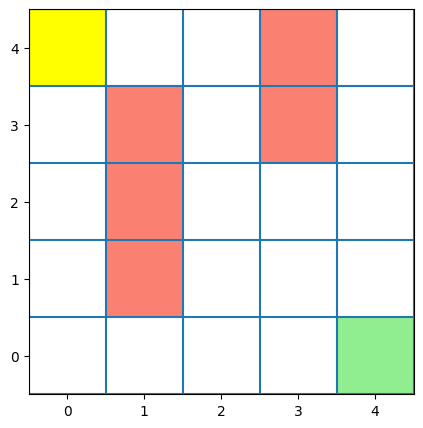

In [7]:
display_gridworld(gridworld)

### Gridworld Environment

In [8]:
#Gridworld environment
class GridworldEnv:
    '''
    Environment of the Gridworld.
    '''
    def __init__(self, gridworld, states, rewards):
        '''
        Creates a gridworld object with the required parameters.
        '''
        self.gridworld = gridworld      #The gridworld array.
        self.states = states
        self.rewards = rewards
        self.current_state = states["start"]    #The current state.


    def step(self, action):
        '''
        Performs one step through the gridworld, and returns the state, reward,
        and the info.
        '''
        next_state = self.take_action(action)        #Gets the next action.
        reward = self.get_reward(next_state)  #Calculates the Reward of the next action.

        if(next_state==states['goal']): #Checks if the next state is terminal.
            done = True
        else:
            done = False

        self.current_state = next_state #Officially moves the agent to the next state.
        return next_state, reward, done

    def take_action(self, action):
        '''
        Gets the next movement in the gridworld based on the action taken.
        '''
        x, y = self.current_state   #Gets the location of the current state.

        #Moves the agent based on the action taken.
        if action == 0:  # Move Up
            x = max(0, x - 1)   #Either moves the x coordinate, or stops on the wall.
        elif action == 1:  # Move Down
            x = min(self.gridworld.shape[1] - 1, x + 1) #Either moves the x coordinate, or stops on the wall.
        elif action == 2:  # Move Left
            y = max(0, y - 1)   #Either moves the y coordinate, or stops on the wall.
        elif action == 3:  # Move Right
            y = min(self.gridworld.shape[0] - 1, y + 1) #Either moves the y coordinate, or stops on the wall.

        #Keeps the state the same if the next state is an obstacle.
        if (x, y) in self.states['obstacles']:
            x, y = self.current_state

        return x, y #Returns the new state

    def get_reward(self, next_state):
        '''
        Calculates the reward based on the next state, and returns the value.
        '''
        if isinstance(next_state, torch.Tensor):
            next_state = tuple(next_state.tolist())

        if next_state == self.states['goal']:           #If the next state is the goal.
            return self.rewards['goal']
        elif next_state in self.states['obstacles']:    #If the next state is an obstacle.
            return self.rewards['obstacle']
        else:   #Gives value of a normal step.
            return self.rewards['step']

    def reset(self):
        '''
        Resets the environment.
        '''
        self.current_state = states['start']
        self.done = False
        return self.current_state

    def render(self, mode='human'):
        '''
        Displays the information about each step of the function.
        '''
        print(f'Current state: {self.current_state}, reward: {self.reward}, done: {self.done}')

## Actor Critic Model

In [9]:
class ActorCriticModel(torch.nn.Module):
    '''
    Represents a Model in Pytorch that uses Three fully-connected layers with ReLU
    activation functions in order to output weights for the 4 movement options.
    '''
    def __init__(self, output_size):
        '''
        Initializes Four different layers that can be used in the neural network to
        update the outputs.
        '''
        super(ActorCriticModel, self).__init__()

        self.shared_layers = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU()
        )

        self.actor = torch.nn.Sequential(
            self.shared_layers,
            torch.nn.Linear(32, output_size),
            torch.nn.Softmax(dim=-1)
        )

        self.critic = torch.nn.Sequential(
            self.shared_layers,
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        '''
        Function performs a fowrard pass of the model.
        '''
        policy = self.actor(x)
        value = self.critic(x)
        return policy, value

## Actor Critic Agent

In [10]:
class Agent:
    '''
    The Agent that is traversing through the gridworld.
    '''
    def __init__(self, env, model):
        '''
        Creates an agent using the environment and the model.
        '''
        self.env = env      #The GridworldEnv object.
        self.model = model  #The ActorCriticModel object.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train(self, num_episodes):
        #Analysis Lists
        self.mse_list = []
        self.stg_list = []
        self.weights_lists = np.zeros((num_episodes, 4))  #Array used for the generalization of the weight trajectories.

        for episode in range(num_episodes): #Runs code for a determined amount of eipsodes.
            for step in range(max_steps):   #Runs an episode only for the amount of steps in max_steps.
                state = torch.tensor(env.current_state, dtype=torch.float32).view(1, -1) #Retreives the current state from the correct tensor in the environment.

                policy, value = model(state) #Identifying the current policy and value from the model.

                action = torch.multinomial(policy, 1).item() #Selecting an action from the policy (Actor).

                next_state, reward, done = env.step(action) #Environment moves the agent to the next state, calculates the state reward, and checks if the agent is done.

                advantage = reward - value.item()  #Calculates the advantage of the policy function.

                #Compute loss of the step.
                loss = -torch.log(policy[0, action]) * advantage + F.smooth_l1_loss(value, torch.tensor(reward).view(1, 1))
                self.optimizer.zero_grad()
                loss.backward()     #Performs backwards pass using the loss value collected from the
                self.optimizer.step()   #Moves the optimizer a step.

                if (step == max_steps) or (done):   #Checks if the agent is done moving in the environment.
                    mse = F.mse_loss(value, torch.tensor(reward).view(1, 1)).item() #Calculates the MSE of the episode.
                    self.mse_list.append(mse)   #Adds MSE to the list of MSE.

                    self.stg_list.append(step)  #Adds the step-to-go value to stg_list.

                    self.weights_lists[episode] = policy.tolist()[0]    #Saves the current weights to the array of weights.

                    env.current_state = env.states['start'] #Resets the current state to the start of the gridworld problem.
                    break

    def run_analysis(self):
        '''
        Runs all of the analysis steps in one function.
        '''
        self.get_MSE_graph()
        self.get_STG_graph()
        self.get_weights_graph()

    def get_MSE_graph(self):
        '''
        Basic graph that plots the Mean Squared Error
        '''
        plt.plot(range(len(self.mse_list)), self.mse_list)

        plt.xlabel('Episode')
        plt.ylabel('Error')
        plt.title('Mean Squared Error')

        #Trend Line
        trend = np.polyfit(range(len(self.mse_list)), self.mse_list, 1)
        p = np.poly1d(trend)
        plt.plot(range(len(self.mse_list)), p(range(len(self.mse_list))),  linestyle="--")

        plt.show()

    def get_STG_graph(self):
        '''
        Basic graph that plots the Step-to-Go Curve
        '''
        plt.plot(range(len(self.stg_list)), self.stg_list)

        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.title('Step-to-Go Curve')

        #Trend Line
        trend = np.polyfit(range(len(self.stg_list)), self.stg_list, 1)
        p = np.poly1d(trend)
        plt.plot(range(len(self.stg_list)), p(range(len(self.stg_list))),  linestyle="--")

        plt.show()

    def get_weights_graph(self):
        '''
        Basic pyplot function that takes the weight_trajectories array, and displays four graphs that
        represent the weight trajectoy of each of the actions in the network.
        '''
        fig, axes = plt.subplots(2, 2, figsize=(10, 8)) #Creates a 2x2 pyplot.
        fig.suptitle('Weight Trajectories') #Labels plot

        for action in range(4):
            '''
            For each of the actions that the agent can take, create a subplot that maps the weight
            trajectory.
            '''
            row, col = divmod(action, 2) #Gets the divisor with the remainder.

            #Sets the subtitle based on the direction of the agent.
            if (action==0):
                axes[row, col].set_title(f'Weight Trajectory (Up)')
            elif (action==1):
                axes[row, col].set_title(f'Weight Trajectory (Down)')
            elif (action==2):
                axes[row, col].set_title(f'Weight Trajectory (Left)')
            elif (action==3):
                axes[row, col].set_title(f'Weight Trajectory (Right)')

            axes[row, col].set_xlabel('Episode') #Sets the X-axis label to the episode .
            #Sets Y-axis label based on teh direction of the agent.
            if (action==0):
                axes[row, col].set_ylabel(f'Weight (Up)')
            elif (action==1):
                axes[row, col].set_ylabel(f'Weight (Down)')
            elif (action==2):
                axes[row, col].set_ylabel(f'Weight (Left)')
            elif (action==3):
                axes[row, col].set_ylabel(f'Weight (Right)')

            #Plots each weight in the array that has the same direction.
            axes[row, col].plot(self.weights_lists[:, action])

        #Displays the plots close to one another.
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

Training Loop

In [11]:
num_episodes = 100
max_steps = 1000

# Implementing the Actor Critic Method

## Training the Agent

In [12]:
model = ActorCriticModel(4)
env = GridworldEnv(gridworld, states, rewards)

agent = Agent(env, model)
agent.train(num_episodes)

## Analysis

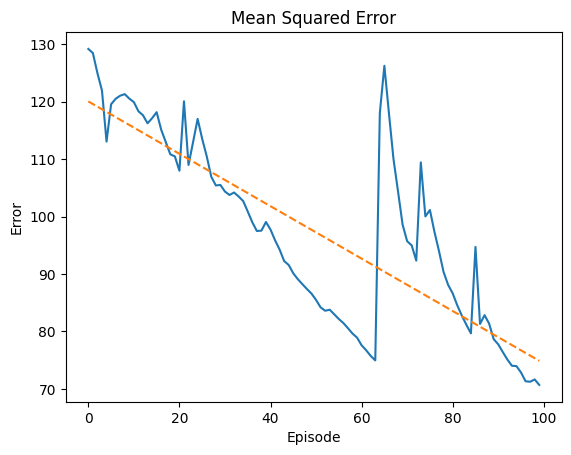

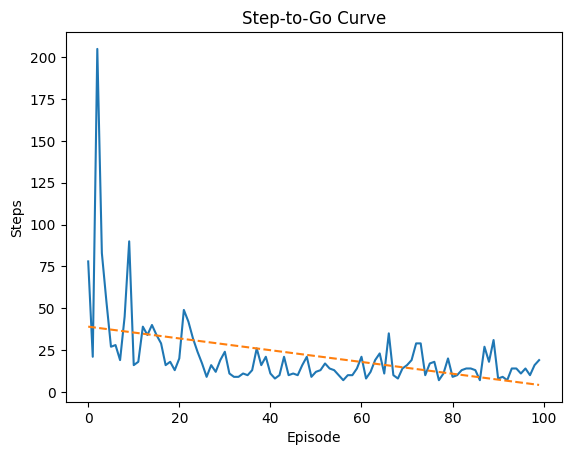

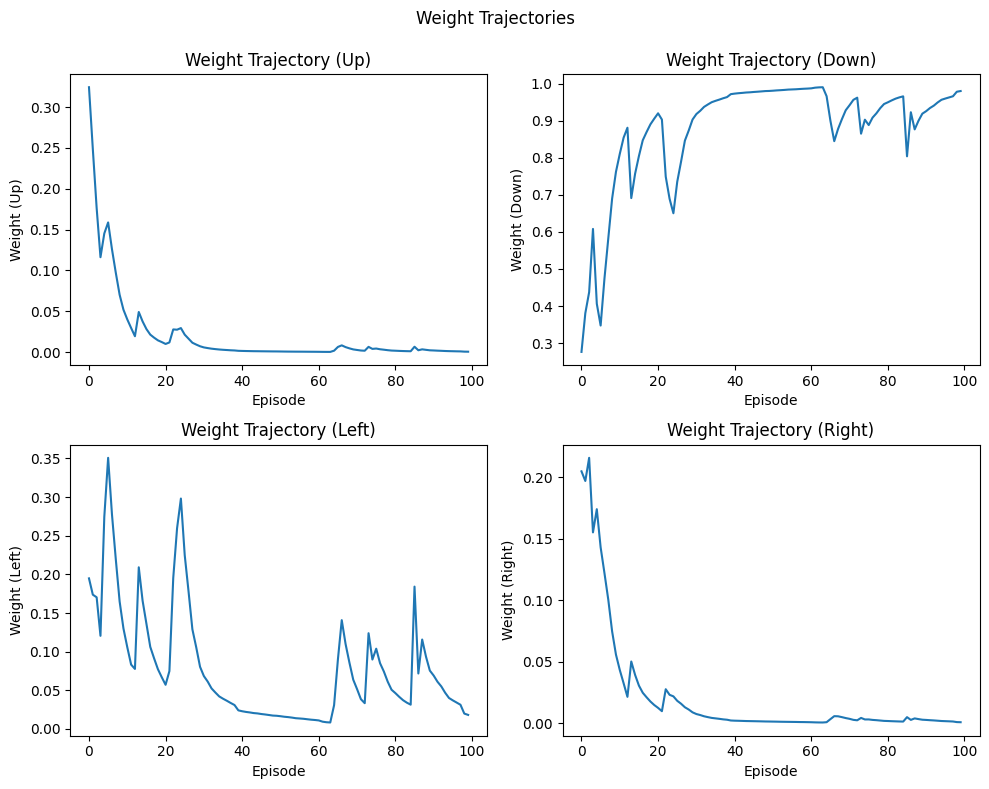

In [14]:
agent.run_analysis()